<a href="https://colab.research.google.com/github/Surojit-KB/UNIV-AI-ML1-Project/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project
# Yelp Restaurant Recommendation System using Collaborative Filtering
The link to the dataset is below:<br>
https://www.yelp.com/dataset <br>
The documenation can be referred for more info on the dataset at:<br>
https://www.yelp.com/dataset/documentation/main <br>
We are going to use collaborative filtering using matrix factorization for building the recommendation system. The scope of the project is really small and is much less than what was envisoned at the beginning due to some unfortunate circumstances.<br>
Project Partners are:


1.   Siva M
2.   Pooja B
3. Ravi Tiwari
4. Surojit B



We start off by importing the necessary libraries. These include pandas and numpy for working with the dataset, matplotlib and seaborn for basic plotting and sci-kit learn/ TensorFlow keras for the modelling part.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot
import pydot
from keras.callbacks import LearningRateScheduler
from IPython.display import display

The dataset will be loaded from Google Drive where it is stored. Please ignore this cell if you plan on importing the data by some other method.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1: Getting the DATA/ Cleaning and EDA

## 1.1 BUSINESS DATA

First we load the Business dataset. Since the size of the dataset is quite huge and loading the whole thing will overload the system RAM, we load it by specifying the datatypes of the column to restrict memory usage.

In [ ]:
#We have restricted the column datatype to 16bit wherever possible
df_business = pd.read_json('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/yelp_academic_dataset_business.json',lines=True,
                           dtype={'business_id':str,
                                   'address':str,
                                   'city':str,
                                   'state':str,
                                   'postal_code':str,
                                   'latitude':np.float16,
                                   'longitude':np.float16,
                                   'stars':np.float16,
                                   "review_count":np.int16,
                                   "is_open":bool,
                                   'attributes':object,
                                   'categories':object,
                                   'hours':object
                           })

In [ ]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.46875,-80.8750,3.5,36,True,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.56250,-111.8750,5.0,4,True,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.46875,-73.5625,5.0,5,True,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.21875,-115.1250,2.5,3,False,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.43750,-111.7500,4.5,26,True,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


To limit the scope of the project, we will be targeting the top 4 cities with the most business. We can consider this as a recommendation system targeting the cities which hold the majority of the business that will attract more customers.

In [ ]:
top_cities=list(df_business['city'].value_counts()[:4].index)
print('The top four cities with the most business are:')
for i in top_cities:
  print(i)

The top four cities with the most business are:
Las Vegas
Toronto
Phoenix
Charlotte


We have obtained the Top 4 cities to be:


1.   Las Vegar
2.   Toronto
3. Phoenix
4. Charlotte

Lets now just focus on these city and the restaurants that are present in this city. We will extract the required data from the business dataset and delete the rest to save space.



In [ ]:
df_top_business=df_business[(df_business['city']==top_cities[0])|(df_business['city']==top_cities[1])|(df_business['city']==top_cities[2])|(df_business['city']==top_cities[3])]

In [ ]:
del df_business

In [ ]:
df_top_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82590 entries, 6 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   82590 non-null  object 
 1   name          82590 non-null  object 
 2   address       82590 non-null  object 
 3   city          82590 non-null  object 
 4   state         82590 non-null  object 
 5   postal_code   82590 non-null  object 
 6   latitude      82590 non-null  float16
 7   longitude     82590 non-null  float16
 8   stars         82590 non-null  float16
 9   review_count  82590 non-null  int16  
 10  is_open       82590 non-null  bool   
 11  attributes    71320 non-null  object 
 12  categories    82388 non-null  object 
 13  hours         64564 non-null  object 
dtypes: bool(1), float16(3), int16(1), object(9)
memory usage: 7.0+ MB


Now we need to get the business that are restaurants from the above dataframe. To do this, we will focus on the `categories` column and select only those rows which have a restaurant tag in the `categories` column.

In [ ]:
rest_loc=df_top_business.categories.str.split(',').explode().str.strip()[(df_top_business.categories.str.split(',').explode().str.strip()=='Restaurants')].index

In [ ]:
df_restaurants=df_top_business.loc[rest_loc]

We pickle this data for future use. It will be provided as part of the project repo.

In [ ]:
df_restuarants.to_pickle('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/df_restaurants')
del df_restaurants

In [13]:
df_restaurants=pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/df_restaurants')
df_restaurants.shape

(22749, 14)

We can see that the dataset we have is very small as compared to the original dataset we had. This just contains around 22000 columns. 

In [ ]:
df_restaurants.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
20,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.18750,-80.7500,3.0,5,False,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",None
33,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.59375,-112.0000,4.0,10,True,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","Food, Pretzels, Bakeries, Fast Food, Restaurants","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
36,fnZrZlqW1Z8iWgTVDfv_MA,Carl's Jr,9595 W Tropicana Ave,Las Vegas,NV,89147,36.09375,-115.3125,2.5,15,False,"{'Alcohol': 'u'none'', 'WiFi': 'u'no'', 'GoodF...","Mexican, Restaurants, Fast Food",None
38,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,843 Kipling Avenue,Toronto,ON,M8Z 5G9,43.62500,-79.5625,3.0,13,False,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Restaurants, Burgers, Food",None
42,fhNf_sg-XzZ3e7HEVGuOZg,Meat Chix And Wieners,6530 S Decatur Blvd,Las Vegas,NV,89118,36.06250,-115.1875,3.0,10,False,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Burgers, Restaurants, American (Traditional), ...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


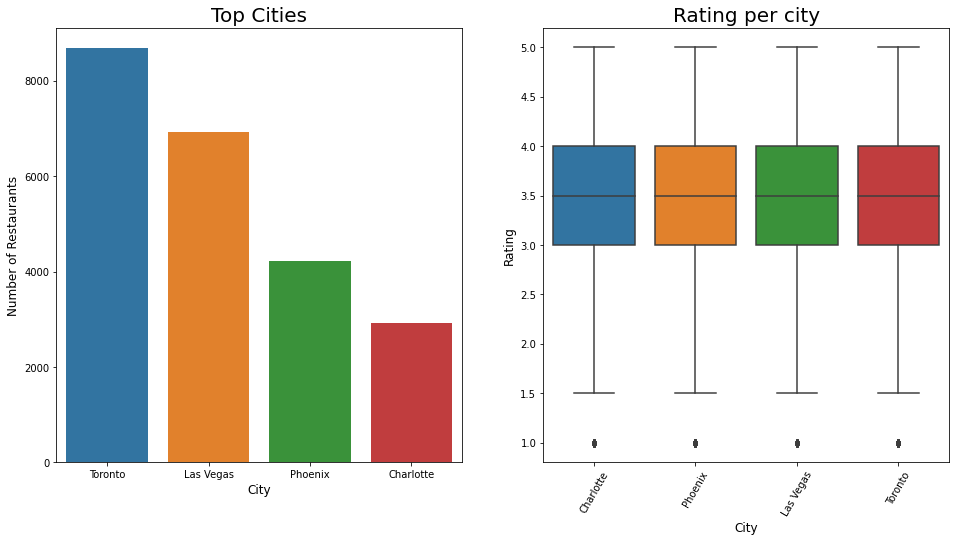

In [ ]:
city_count=df_restaurants.city.value_counts().sort_values(ascending=False)
fig,ax = plt.subplots(1,2,figsize=(16, 8))
sns.barplot(city_count.index, city_count.values,ax=ax[0])
sns.boxplot(x='city',y='stars',data=df_restaurants,ax=ax[1])
ax[1].set_title("Rating per city",fontsize = 20);
ax[0].set_title("Top Cities",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 60)
ax[0].set_ylabel('Number of Restaurants', fontsize = 12)
ax[0].set_xlabel('City', fontsize = 12)
ax[1].set_ylabel('Rating', fontsize = 12)
ax[1].set_xlabel('City', fontsize = 12);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


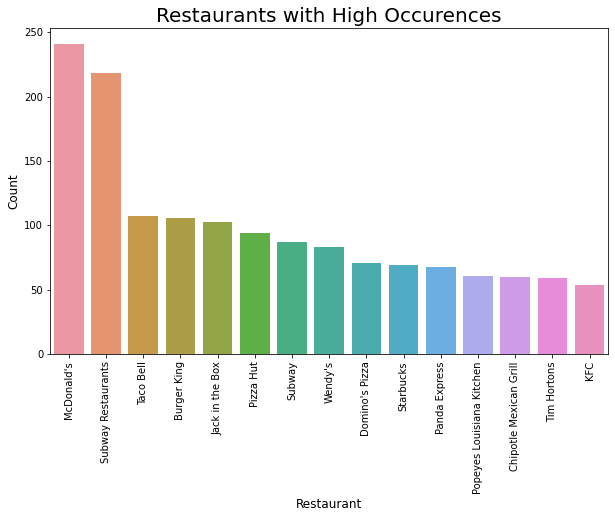

In [ ]:
res_count = df_restaurants.name.value_counts()
res_count = res_count.sort_values(ascending = False)
res_count = res_count.iloc[0:15]
fig = plt.figure(figsize=(10, 6))
sns.barplot(res_count.index, res_count.values)
plt.title("Restaurants with High Occurences",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Restaurant', fontsize = 12);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


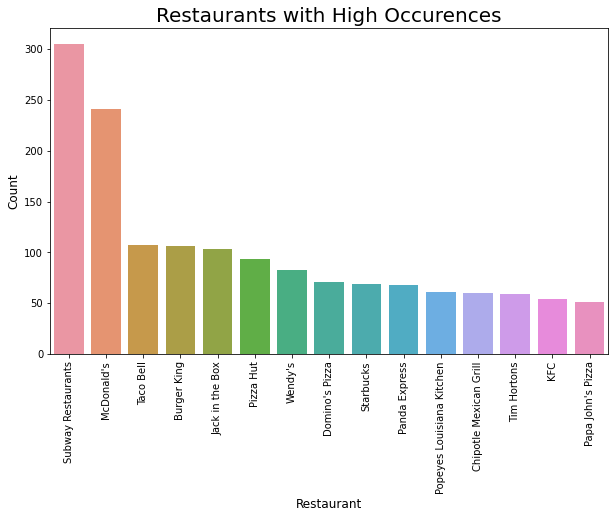

In [ ]:
df_restaurants.loc[df_restaurants.name == 'Subway', 'name'] = 'Subway Restaurants'
res_count = df_restaurants.name.value_counts()
res_count = res_count.sort_values(ascending = False)
res_count = res_count.iloc[0:15]
fig = plt.figure(figsize=(10, 6))
sns.barplot(res_count.index, res_count.values)
plt.title("Restaurants with High Occurences",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Restaurant', fontsize = 12);

In [ ]:
burg_df=df_restaurants.loc[(df_restaurants.name == 'McDonald\'s') | (df_restaurants.name == 'Burger King')]
pizza_df = df_restaurants.loc[(df_restaurants.name == 'Pizza Hut') | (df_restaurants.name == 'Domino\'s Pizza')]

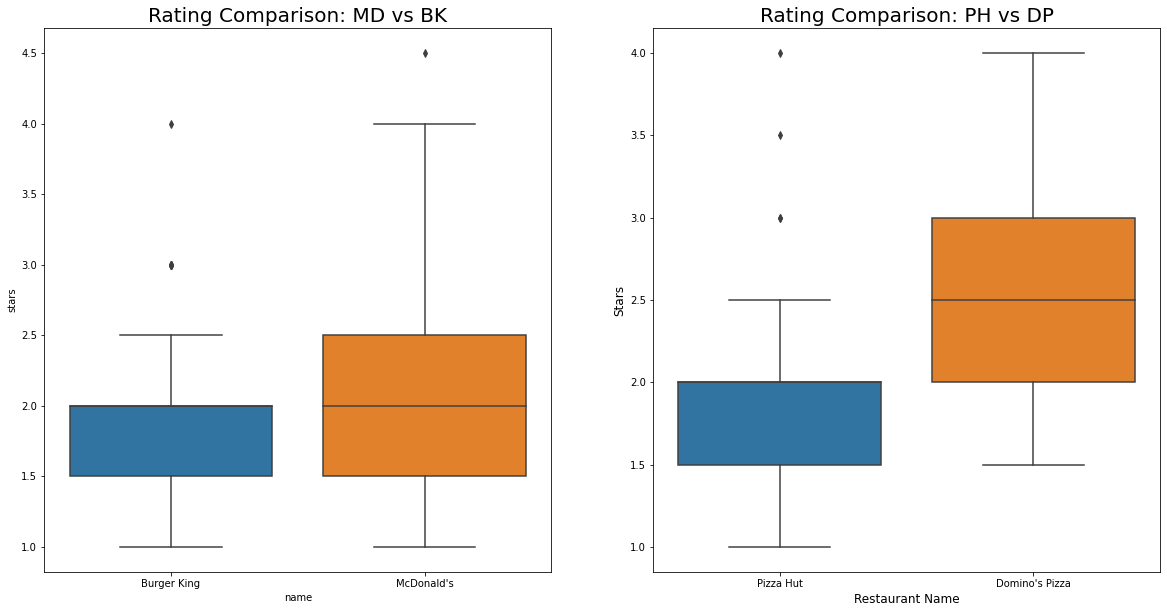

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20, 10))
sns.boxplot(x = 'name', y = 'stars', data = burg_df,ax=ax[0])
sns.boxplot(x='name',y='stars',data=pizza_df,ax=ax[1])
ax[0].set_title("Rating Comparison: MD vs BK",fontsize = 20)
ax[1].set_title("Rating Comparison: PH vs DP",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
plt.xlabel('Restaurant Name', fontsize = 12);

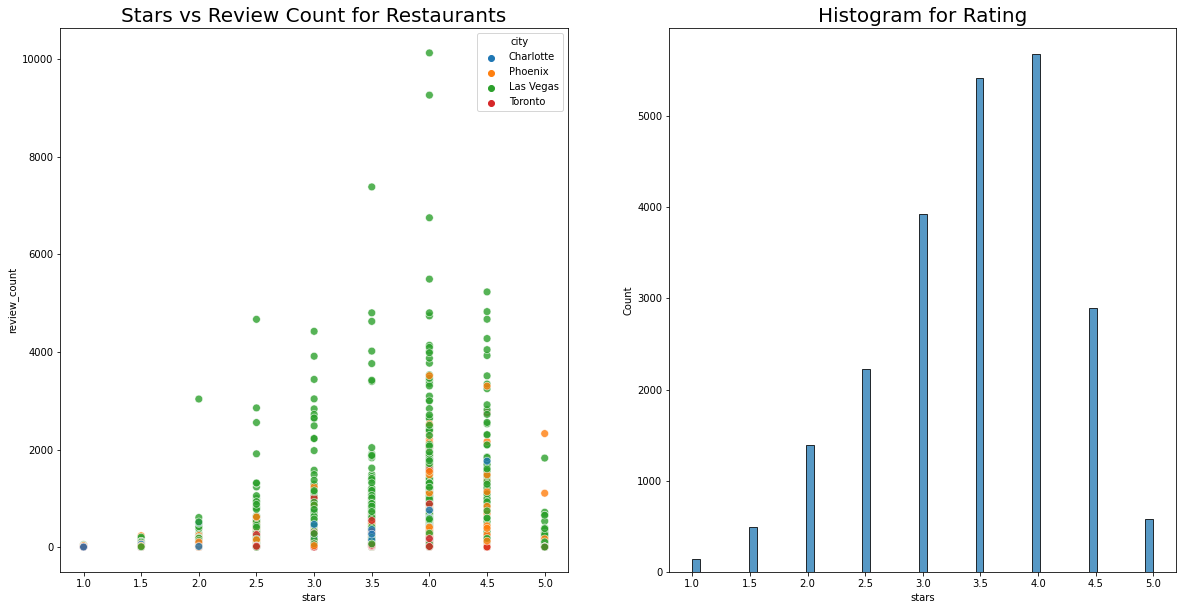

In [26]:
fig,ax = plt.subplots(1,2,figsize=(20, 10))
sns.scatterplot(x='stars',y='review_count',hue='city',data=df_restaurants,ax=ax[0],alpha=0.8,s=60)
sns.histplot(x='stars',data=df_restaurants,ax=ax[1])
ax[0].set_title('Stars vs Review Count for Restaurants',fontsize=20)
ax[1].set_title('Histogram for Rating',fontsize=20);

## 1.2.  USER DATA

Now we will turn our focus on the user dataset. Here too, the size of the data is too huge to load into memory. So in addition to specifying the datatypes, we are going to work with chunks of data using the `chunksize` argument while loading the dataset. The `chunksize` has been specified to 100000, which means only this much data will be loaded at one time. We will drop the unnecessary columns and then append this data to the user dataframe.

In [ ]:
#The user data columns was obtained by loading just 1 row initially and the datatypes were assigned
user_dtype={'user_id':str, 'name':str, 'review_count':np.int16, 'yelping_since':str, 'useful':np.int16, 'funny':np.int16,
       'cool':np.int16, 'elite':object, 'friends':object, 'fans':np.int32, 'average_stars':np.float16, 'compliment_hot':np.int16,
       'compliment_more':np.int16, 'compliment_profile':np.int16, 'compliment_cute':np.int16,
       'compliment_list':np.int16, 'compliment_note':np.int16, 'compliment_plain':np.int16,
       'compliment_cool':np.int16, 'compliment_funny':np.int16, 'compliment_writer':np.int16,
       'compliment_photos':np.int16}
date_column=['yelping_since']

In [ ]:
size = 100000
user= pd.read_json('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/yelp_academic_dataset_user.json', lines=True,
                      chunksize=size,nrows=size*20,dtype=user_dtype,convert_dates=date_column) #This just provides the JSON reader object

In [ ]:
#Here we load the actual data
df_users=pd.DataFrame()
for chunk in user:
  df_chunk=pd.DataFrame(chunk)
  df_users=pd.concat([df_users,df_chunk],axis=0)

In [ ]:
df_users.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,2007-07-06 03:27:11,628,225,227,,"oeMvJh94PiGQnx_6GlndPQ, wm1z1PaJKvHgSDRKfwhfDg...",14,3.570312,3,2,1,0,1,11,15,22,22,10,0
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,2008-04-28 01:29:25,790,316,400,"2008,2009,2010,2011,2012,2013","ly7EnE8leJmyqyePVYFlug, pRlR63iDytsnnniPb3AOug...",27,3.839844,36,4,5,2,1,33,37,63,63,21,5
2,zZUnPeh2hEp0WydbAZEOOg,Martin,60,2008-08-28 23:40:05,151,125,103,2010,"Uwlk0txjQBPw_JhHsQnyeg, Ybxr1tSCkv3lYA0I1qmnPQ...",5,3.439453,9,6,0,1,0,3,7,17,17,4,1
3,QaELAmRcDc5TfJEylaaP8g,John,206,2008-09-20 00:08:14,233,160,84,2009,"iog3Nyg1i4jeumiTVG_BSA, M92xWY2Vr9w0xoH8bPplfQ...",6,3.080078,2,1,0,0,0,7,14,7,7,2,0
4,xvu8G900tezTzbbfqmTKvA,Anne,485,2008-08-09 00:30:27,1265,400,512,"2009,2010,2011,2012,2014,2015,2016,2017,2018","3W3ZMSthojCUirKEqAwGNw, eTIbuu23j9tOgmIa9POyLQ...",78,4.371094,8,9,2,1,1,22,28,31,31,19,31


In [ ]:
df_users.describe()

,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
count,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06,1.968703e+06
mean,2.216930e+01,3.699754e+01,1.600239e+01,1.951089e+01,1.458824e+00,NaN,1.980362e+00,3.004191e-01,1.873203e-01,1.614454e-01,7.019241e-02,1.305939e+00,2.816663e+00,2.785878e+00,2.785878e+00,1.058364e+00,1.014877e+00
std,7.674226e+01,3.776958e+02,2.607460e+02,3.236825e+02,1.667521e+01,0.000000e+00,7.229082e+01,1.275309e+01,1.507502e+01,1.162099e+01,9.967903e+00,3.714887e+01,8.223036e+01,8.348484e+01,8.348484e+01,3.154894e+01,5.764002e+01
min,0.000000e+00,-3.260300e+04,-3.217400e+04,-3.263400e+04,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.723000e+04,0.000000e+00,-2.502800e+04,-2.502800e+04,0.000000e+00,-2.271000e+04
25%,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.880859e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.500000e+01,1.300000e+01,3.000000e+00,3.000000e+00,0.000000e+00,4.570312e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.445500e+04,3.180800e+04,3.200300e+04,3.260100e+04,1.156800e+04,5.000000e+00,2.545200e+04,1.350100e+04,1.417900e+04,1.365400e+04,1.266900e+04,1.591600e+04,2.554600e+04,2.996500e+04,2.996500e+04,1.544500e+04,2.766000e+04


## 1.3. REVIEW DATA

Finally, we come to the review dataset. This is the largest dataset around 6GB in size. We will load in smaller chunks, with `chunksize` to be 100000.
Also, we will delete the `review_id` and the `text` columns since we don't need the `review_id` column in our model and we are also not attempting any NLP shenanigans which means we don't need `text` column.

In [ ]:
size = 100000
review = pd.read_json('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/yelp_academic_dataset_review.json', lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':np.float16,
                             'date':str,'text':str,'useful':np.int16,
                             'funny':np.int16,'cool':np.int16},
                      chunksize=size,nrows=size*20)

In [ ]:
df_reviews=pd.DataFrame()
for chunk in review:
  df_chunk=pd.DataFrame(chunk)
  df_chunk=df_chunk.drop(['review_id','text'],axis=1)
  df_reviews=pd.concat([df_reviews,df_chunk],axis=0)

Next, we only keep those reviews, which are related to our business and remove the other.

In [ ]:
df_reviews=df_reviews[df_reviews['business_id'].isin(df_restaurants['business_id'])]
df_reviews=df_reviews.drop('date',axis=1)

In the User data, there is a column having the years the person was `elite`. Instead of keeping that info, we are just going to keep the total numerber of years. Same goes for the `friends`, instead of the actual id of friends, we will keep the number of friends the guy/gal has.

In [ ]:
df_users['n_elite']=df_users['elite'].apply(lambda x: len([i for i in x.replace(","," ").split()]))
df_users=df_users.drop('elite',axis=1)
df_users['n_friends']=df_users['friends'].apply(lambda x: len([i for i in x.replace('None',"").replace(","," ").split()]))
df_users=df_users.drop('friends',axis=1)
df_users=df_users.drop('yelping_since',axis=1)
df_users=df_users.rename(columns={"useful":'user_useful',"funny":"user_funny","cool":"user_cool"})

In [ ]:
df_users.head()

,user_id,name,review_count,user_useful,user_funny,user_cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,n_elite,n_friends
0,ntlvfPzc8eglqvk92iDIAw,Rafael,553,628,225,227,14,3.570312,3,2,1,0,1,11,15,22,22,10,0,0,45
1,FOBRPlBHa3WPHFB5qYDlVg,Michelle,564,790,316,400,27,3.839844,36,4,5,2,1,33,37,63,63,21,5,6,213
4,xvu8G900tezTzbbfqmTKvA,Anne,485,1265,400,512,78,4.371094,8,9,2,1,1,22,28,31,31,19,31,9,895
7,f4_MRNHvN-yRn7EA8YWRxg,Jennifer,822,4127,2446,2878,137,3.630859,483,81,62,35,24,193,541,623,623,293,172,8,755
8,UYACF30806j2mfbB5vdmJA,Justin,14,68,21,34,4,3.750000,0,3,0,0,0,3,4,0,0,2,1,0,85


In [ ]:
df_reviews.head()

,user_id,business_id,stars,useful,funny,cool
3,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0
16,2hRe26HSCAWbFRn5WChK-Q,d4qwVw4PcN-_2mK2o1Ro1g,1.0,0,0,0
19,QodunSzok4nIYFNrTSGesQ,poSV39UqEg-gpESXafS9-g,3.0,0,0,0
21,RR-2nouBn408e3djxC470g,d4qwVw4PcN-_2mK2o1Ro1g,5.0,0,0,0
24,-Co-ReNx_lXT1xL_Rr0B2g,XZbuPXdyA0ZtTu3AzqtQhg,4.0,0,1,0


In [ ]:
df_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
20,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.18750,-80.7500,3.0,5,False,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",None
33,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.59375,-112.0000,4.0,10,True,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","Food, Pretzels, Bakeries, Fast Food, Restaurants","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
36,fnZrZlqW1Z8iWgTVDfv_MA,Carl's Jr,9595 W Tropicana Ave,Las Vegas,NV,89147,36.09375,-115.3125,2.5,15,False,"{'Alcohol': 'u'none'', 'WiFi': 'u'no'', 'GoodF...","Mexican, Restaurants, Fast Food",None
38,rVBPQdeayMYht4Uv_FOLHg,Gourmet Burger Company,843 Kipling Avenue,Toronto,ON,M8Z 5G9,43.62500,-79.5625,3.0,13,False,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Restaurants, Burgers, Food",None
42,fhNf_sg-XzZ3e7HEVGuOZg,Meat Chix And Wieners,6530 S Decatur Blvd,Las Vegas,NV,89118,36.06250,-115.1875,3.0,10,False,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Burgers, Restaurants, American (Traditional), ...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


We also just focus on the Users who have provided the review for the business that are focusing on.

In [ ]:
df_users=df_users[df_users['user_id'].isin(df_reviews['user_id'])]

We pickle the datasets and store it for furtehr use.

In [ ]:
df_reviews.to_pickle('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/df_reviews')
del df_reviews
df_users.to_pickle('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/df_users')
del df_users

In [3]:
df_reviews=pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/df_reviews')
df_users=pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-ML1/Project/df_users')

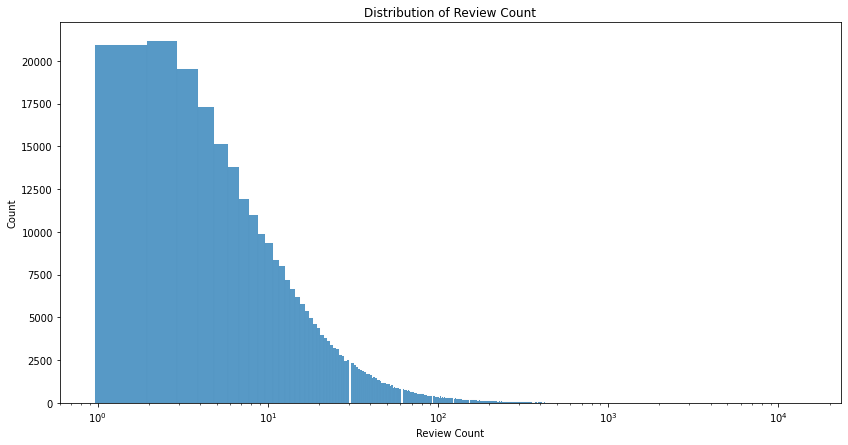

In [27]:
fig=plt.figure(figsize=(14,7))
sns.histplot(df_users.review_count)
plt.xscale('log')
plt.xlabel('Review Count')
plt.title('Distribution of Review Count');

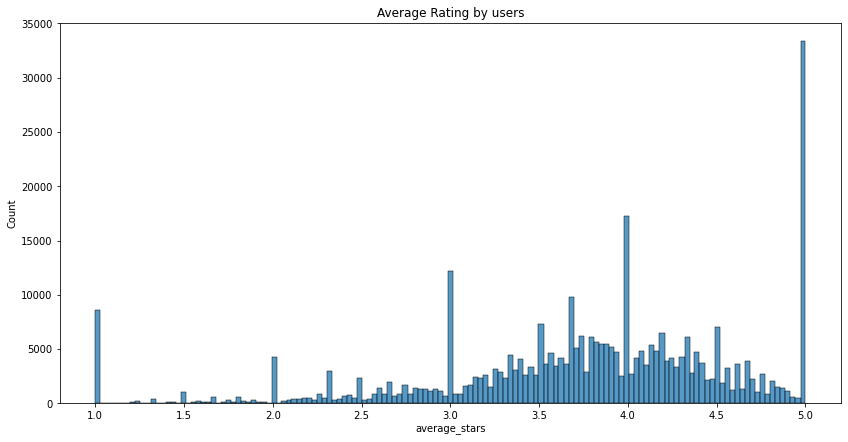

In [36]:
fig=plt.figure(figsize=(14,7))
sns.histplot(df_users.average_stars)
plt.title('Average Rating by users');

Now, we get the data ready for modelling. Columns `user_id`, `business_id` and `stars` are going to be used from the reviews dataset along with the user info.

In [ ]:
df_merge=pd.merge(df_users['user_id'],df_reviews[['user_id','business_id','stars']],on='user_id', how='inner')

In [ ]:
users = df_merge.user_id.unique()
rest = df_merge.business_id.unique()

Next,we remove the `user_id` which are in the form of Hashtags and replace them with numerical ID's. This will be done for `business_id` as well. 

In [ ]:
userid2idx = {o:i for i,o in enumerate(users)}
rest2idx = {o:i for i,o in enumerate(rest)}

In [ ]:
df_merge['user_id'] = df_merge['user_id'].apply(lambda x: userid2idx[x])
df_merge['business_id'] = df_merge['business_id'].apply(lambda x: rest2idx[x])
df_users['user_id'] = df_users['user_id'].apply(lambda x: userid2idx[x])

In [ ]:
df_restaurants = df_restaurants[df_restaurants['business_id'].isin(rest)]
df_restaurants['business_id']= df_restaurants['business_id'].apply(lambda x: rest2idx[x])

In [ ]:
df_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
20,2274,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.18750,-80.7500,3.0,5,False,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",None
33,2926,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.59375,-112.0000,4.0,10,True,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","Food, Pretzels, Bakeries, Fast Food, Restaurants","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'..."
36,1075,Carl's Jr,9595 W Tropicana Ave,Las Vegas,NV,89147,36.09375,-115.3125,2.5,15,False,"{'Alcohol': 'u'none'', 'WiFi': 'u'no'', 'GoodF...","Mexican, Restaurants, Fast Food",None
38,4286,Gourmet Burger Company,843 Kipling Avenue,Toronto,ON,M8Z 5G9,43.62500,-79.5625,3.0,13,False,"{'RestaurantsPriceRange2': '2', 'RestaurantsAt...","Restaurants, Burgers, Food",None
42,1074,Meat Chix And Wieners,6530 S Decatur Blvd,Las Vegas,NV,89118,36.06250,-115.1875,3.0,10,False,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Burgers, Restaurants, American (Traditional), ...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."


Now, we will get the unique users and businesses that we have. This will be useful for the emd=bedding of the data.

In [ ]:
nusers = df_merge['user_id'].nunique()
nrest= df_merge['business_id'].nunique()
nusers, nrest

(346092, 6564)

# PART 2. Modelling

First we split the data into train and validation set, with an 80/20 split.

In [ ]:
train_indices, val_indices = train_test_split(range(df_merge.shape[0]), train_size=0.8)
trdf = df_merge.iloc[train_indices]
valdf = df_merge.iloc[val_indices]
trdf.shape, valdf.shape

((532039, 3), (133010, 3))

We are going to use a latent factor of size 50 for our embedding and also regularization of 1r-4. These parameters should have been obtained from the cross-validation but wasn't done to limit the scope and work with the time constraints.

In [ ]:
L = 50
REG=1e-4

Now, we create the bias and the embedding for the model using the user and the restuarant info. We multiply the embdding and add the bias to get our residual loss for out Regression model, which we are going to minimize. The optimizer has been chosen to be ADAM and we are going to use a learning rate scheduler to reduce the learning rate after each epoch.

In [ ]:
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    return Flatten(name=name+'_flat')(x)

In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [ ]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
rest_input, rLmat = embedding_input('rest_input', nrest, L, REG)

In [ ]:
user_bias = create_bias('user_bias', user_input, nusers, REG)
rest_bias = create_bias('rest_bias', rest_input, nrest, REG)

In [ ]:
residual = Dot(axes=2, name="residual")([uLmat, rLmat])

In [ ]:
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

In [ ]:
regression = Add(name="regression")([user_bias, rest_bias, residflat])

In [ ]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

In [ ]:
cs = sigmoid_maker(0, 5.5)

In [ ]:
output = Activation(cs, name="Sigmoid_Range")(regression)

This is the code for the learning rate scheduler which updates the learning rate after each epoch. I wanted to use the One Cycle Policy for the learning rate, but couldn't find the necessary function in the library.

In [ ]:
def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]

In [ ]:
model = Model([user_input, rest_input], output)
model.compile(Adam(0.01), loss='mse')

Next we fit the model for 5 epochs with batch_size of 512 and starting learning rate of 0.001. The learning rate will be decreased by a factor of 0.1 after each epoch.

In [ ]:
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=512, epochs=5, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars),callbacks=callbacks)

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
1040/1040 [==============================] - 96s 92ms/step - loss: 2.2080 - val_loss: 1.9113
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009999999776482583.
1040/1040 [==============================] - 95s 92ms/step - loss: 1.7674 - val_loss: 1.7867
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999310821295e-05.
1040/1040 [==============================] - 96s 93ms/step - loss: 1.6942 - val_loss: 1.7831
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999019782991e-06.
1040/1040 [==============================] - 96s 92ms/step - loss: 1.6933 - val_loss: 1.7828
Epoch 5/5

Epoch 00005: LearningRateScheduler reducing learning rate to 9.99999883788405e-07.
1040/1040 [==============================] - 97s 93ms/step - loss: 1.6941 - val_loss: 1.7828


# PART 3. PREDICTION

Here, we can do the predictions for the individual users and business. Also, we have defined a function which is going to give us the Top 5 recommendation for a particular user.

In [ ]:
def predict(userid,restid):
  pred=model.predict([np.array([userid]), np.array([restid])])
  pred=round(float(pred)*2)/2
  return pred

In [ ]:
def user_pred(user_id):
  df_user_id=df_merge[(df_merge['user_id']==user_id)].copy()
  rest_not_visited=list(set(df_restaurants.business_id)-set(df_user_id.business_id))
  df_user_id_pred=df_restaurants[df_restaurants.business_id.isin(rest_not_visited)].copy()
  df_user_id_pred['user_id']=user_id
  df_user_id_pred['prediction']=model.predict([df_user_id_pred['user_id'],df_user_id_pred['business_id']])
  df_user_id_pred['user_name']=df_users[df_users['user_id']==user_id].name.values[0]
  df_user_id_pred=df_user_id_pred.sort_values('prediction',ascending=False)[:5]
  display(df_user_id_pred.head(5))

Let's see the prediction for USER NUMBER 6.


In [ ]:
user_pred(6)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,user_id,prediction,user_name
12657,580,Brew Tea Bar,"7380 S Rainbow Blvd, Ste 101",Las Vegas,NV,89139,36.06250,-115.250,5.0,1827,True,"{'HasTV': 'False', 'OutdoorSeating': 'True', '...","Restaurants, Food, Cafes, Tea Rooms, Bubble Te...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",6,4.802965,Lisa Marie
6245,384,Hobak Korean BBQ,"5808 Spring Mountain Rd, Ste 101",Las Vegas,NV,89146,36.12500,-115.250,4.5,1850,True,"{'OutdoorSeating': 'False', 'DogsAllowed': 'Fa...","Barbeque, Restaurants, Korean","{'Monday': '11:30-23:0', 'Tuesday': '11:30-23:...",6,4.627387,Lisa Marie
20725,312,Baguette Cafe,"8359 W Sunset Rd, Ste 100",Las Vegas,NV,89113,36.06250,-115.250,4.5,1284,True,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Delis, Vegan, Restaurants, French, Food, Coffe...","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ...",6,4.616957,Lisa Marie
51068,1655,VegeNation,"616 Carson Ave, Ste 120",Las Vegas,NV,89101,36.15625,-115.125,4.5,1638,True,"{'Caters': 'True', 'RestaurantsDelivery': 'Tru...","Live/Raw Food, Bars, Vegetarian, Restaurants, ...","{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...",6,4.604917,Lisa Marie
34429,414,Chubby Cattle,"3400 S Jones Blvd, Ste 15",Las Vegas,NV,89146,36.12500,-115.250,4.5,1738,True,"{'ByAppointmentOnly': 'False', 'RestaurantsTab...","Chinese, Barbeque, Mongolian, Restaurants, Hot...","{'Monday': '17:0-23:45', 'Tuesday': '17:0-23:4...",6,4.592916,Lisa Marie


Looks like Lisa Marie has a liking for restaurants in Las Vegas and mostly loves cafe's.

This brings us to the end of the project. I would like to say that this is by no means what I had in mind for the project. Due to unfortunate circumstances, I had to limit the scope of the project too heavily just so that I could submit something. I would have loved to go deeper into the topic and build a better project which provides very good insight into the dataset. I deeply regret that and am not at all proud of what I am submitting.